<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Segment customers of a website - P5</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">| Modeling notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [2]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from statsmodels.graphics.gofplots import qqplot

## df_analysis
import io
import gc
import timeit
import math
from math import pi
from collections import Counter
from math import prod
import scipy.stats as stats

## Scikit Learn 
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Yellowbrick - Scikit Learn 
from yellowbrick.cluster import KElbowVisualizer

# Own specific functions 
from functions import *

%matplotlib inline
sns.set_theme(style="darkgrid")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [3]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
            
        if type_analysis == "summarized":
            print("\n")
        
        if type_analysis is None or type_analysis != "summarized":
            pd.set_option("display.max_rows", None) # show full of showing rows
            pd.set_option("display.max_columns", None) # show full of showing cols
            pd.set_option("display.max_colwidth", None) # show full width of showing cols
            pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    
            
            if type_analysis is None or type_analysis != "complete":
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            elif type_analysis == "complete" and (df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0):
                df_resume["unique"] = list(df.nunique())
                df_desc = pd.DataFrame(df.describe().T).reset_index()
                df_desc = df_desc.rename(columns={"index": "name"})
                df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
                df_resume = df_resume[ORDERING_COMPLETE]
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            
            display(df_resume.sort_values("records", ascending=False))
            
            pd.reset_option("display.max_rows") # reset max of showing rows
            pd.reset_option("display.max_columns") # reset max of showing cols
            pd.reset_option("display.max_colwidth") # reset width of showing cols
            pd.reset_option("display.float_format") # reset show full content in cell
            
        # deleting dataframe to free memory
        if type_analysis == "complete":
            
            if df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0:
                del [[df_resume, df_desc]]
            else:
                del [[df_resume]]
            
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to load the dateset resulting from the PCA
</div>

In [4]:
df_data = pd.read_csv(r"datasets\data_to_model.csv")

In [5]:
df_data.head()

,customer_unique_id,recency,frequency,avg_basket,satisfaction,rfm_score_label,bed_bath_table,health_beauty,sports_leisure,computers_accessories,...,telephony,toys,cool_stuff,perfumery,baby,stationery,electronics,others,avg_product_weight_g_total,avg_product_volume_cc_total
0,dc4b0942fb780633d44f4f73ff69dd92,6,1,5.265287,5.0,New Customers,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,7.357552,87.970157
1,11ccf36669e0483ac53abfeb566679b6,7,1,6.099716,5.0,New Customers,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,8.233620,53.368679
2,2fc09b16746a702ba0aab85c6a9a7438,11,1,4.418190,5.0,New Customers,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,7.971544,36.166672
3,4ecdb958c2b1b099ed5e56d9ca156773,13,1,8.197856,5.0,Promising,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,12.803929,129.095850
4,164b46961e3ef442750fed496929369f,13,1,7.128768,5.0,Promising,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,8.647458,65.014023


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Dimensionality Reduction</h2>
</div>

<div class="alert alert-block alert-info">
    <p>For the <b>Dimensionality Reduction</b> we are going to work as follow</p>
    <ol>
        <li>Selecting the resulting <b>features of RFM</b> to make the modelisations</li>
            <ul style="list-style-type: disc;">
                <li>recency</li>
                <li>frequency</li>
                <li>avg_basket</li>
                <li>satisfaction</li>
                <li>rfm_score_label</li>
            </ul> 
        <li>Making the modelisation with <b>all features</b></li>
    </ol> 
</div>

In [45]:
data_sample_reduced = df_data[["recency", "frequency", "satisfaction", "avg_basket", "rfm_score_label"]].copy()
data_sample_completed = df_data.drop("customer_unique_id", axis=1).copy()

In [46]:
df_analysis(data_sample_reduced, "data_sample_reduced", type_analysis="complete")


Analysis of data_sample_reduced dataset
--------------------------------------------------------------------
- Dataset shape:                  66934 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  1642
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 2.6+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,recency,int64,66934,318,0,0.00000,160.54345,0.00000,84.00000,162.00000,235.00000,320.00000,88.82827
1,frequency,int64,66934,9,0,0.00000,1.02564,1.00000,1.00000,1.00000,1.00000,10.00000,0.17772
2,satisfaction,float64,66934,26,0,0.00000,4.07370,1.00000,4.00000,5.00000,5.00000,5.00000,1.35355
3,avg_basket,float64,66934,26465,0,0.00000,7.51133,3.40463,6.00023,6.81154,7.64593,135.91949,3.42620
4,rfm_score_label,object,66934,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_analysis(data_sample_completed, "data_sample_completed", type_analysis="complete")


Analysis of data_sample_completed dataset
--------------------------------------------------------------------
- Dataset shape:                  66934 rows and 24 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  870
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 12.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,recency,int64,66934,318,0,0.00000,160.54345,0.00000,84.00000,162.00000,235.00000,320.00000,88.82827
1,frequency,int64,66934,9,0,0.00000,1.02564,1.00000,1.00000,1.00000,1.00000,10.00000,0.17772
22,avg_product_weight_g_total,float64,66934,5363,0,0.00000,9.55170,0.00000,8.15987,9.27146,10.73217,14.87272,1.84174
21,others,float64,66934,521,0,0.00000,18.66740,0.00000,0.00000,0.00000,0.00000,100.00000,38.72633
20,electronics,float64,66934,58,0,0.00000,3.08867,0.00000,0.00000,0.00000,0.00000,100.00000,17.24402
19,stationery,float64,66934,65,0,0.00000,2.66554,0.00000,0.00000,0.00000,0.00000,100.00000,16.03644
18,baby,float64,66934,114,0,0.00000,2.93127,0.00000,0.00000,0.00000,0.00000,100.00000,16.74907
17,perfumery,float64,66934,71,0,0.00000,3.03654,0.00000,0.00000,0.00000,0.00000,100.00000,17.08524
16,cool_stuff,float64,66934,83,0,0.00000,2.97869,0.00000,0.00000,0.00000,0.00000,100.00000,16.91376
15,toys,float64,66934,101,0,0.00000,3.41995,0.00000,0.00000,0.00000,0.00000,100.00000,18.07461


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Datapreprocessing</h3>
</div>

<div class="alert alert-block alert-info">
     <p>We are going to process the features as follows</p>
    <p><b>Ordinal features</b><br>
    Transforming the feature through OrdinalEncoder</p>
    <p><b>Numerical features</b><br>
    Normalizing the features through RobustScaler due to all of them do not have a normal distribution and to avoid possibles outliers</p>
</div>

In [61]:
DICTIONARY_DFS = {
    "reduced" : data_sample_reduced,
    "completed" : data_sample_completed
}

In [64]:
for key, value in DICTIONARY_DFS.items():
    
    NUMERICAL_FEATURES = list(value._get_numeric_data())
    ORDINAL_FEATURES = ["rfm_score_label"]
    
    ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=[["Lost customers", "Hibernating customers", "Cannot Lose Them", "At Risk", "About To Sleep",\
                                                             "Need Attention", "Promising", "New Customers", "Potential Loyalist", "Loyal", "Champions"]]))
    numerical_pipeline = make_pipeline(RobustScaler())
    
    preprocessor = make_column_transformer(
                (ordinal_pipeline, ORDINAL_FEATURES),
                (numerical_pipeline, NUMERICAL_FEATURES)
    )
    
    # Droping the real columns and concatenating the encoder columns
    globals()["sample_scaled_" + key] = preprocessor.fit_transform(value)
    
    globals()["sample_scaled_" + key] = pd.DataFrame(globals()["sample_scaled_" + key], index=value.index, columns=value.columns)

In [67]:
sample_scaled_reduced.head()

,recency,frequency,satisfaction,avg_basket,rfm_score_label
0,7.0,-1.033113,0.0,0.0,-0.939567
1,7.0,-1.026490,0.0,0.0,-0.432532
2,7.0,-1.000000,0.0,0.0,-1.454300
3,6.0,-0.986755,0.0,0.0,0.842388
4,6.0,-0.986755,0.0,0.0,0.192764


In [66]:
sample_scaled_completed.head()

,recency,frequency,avg_basket,satisfaction,rfm_score_label,bed_bath_table,health_beauty,sports_leisure,computers_accessories,furniture_decor,...,telephony,toys,cool_stuff,perfumery,baby,stationery,electronics,others,avg_product_weight_g_total,avg_product_volume_cc_total
0,7.0,-1.033113,0.0,-0.939567,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,-0.744048,0.290389
1,7.0,-1.026490,0.0,-0.432532,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,-0.403470,-0.487425
2,7.0,-1.000000,0.0,-1.454300,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,-0.505354,-0.874113
3,6.0,-0.986755,0.0,0.842388,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1.373274,1.214863
4,6.0,-0.986755,0.0,0.192764,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,-0.242587,-0.225647


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Principal component analysis - PCA</h3>
</div>

In [87]:
for key, value in DICTIONARY_DFS.items():
    
    # Numbers of components to calculate to PCA
    globals()["n_comp_" + key] = globals()["sample_scaled_" + key].shape[1]
    
    # Selecting the features to analyse with PCA
    globals()["X_" + key] = globals()["sample_scaled_" + key].values
    globals()["index_values_" + key] = globals()["sample_scaled_" + key].index
    globals()["features_" + key] = globals()["sample_scaled_" + key].columns
    
    # Principal components determination 
    globals()["pca_" + key] = PCA(n_components=globals()["n_comp_" + key]).fit(globals()["X_" + key])
    
    # Making a dataset based on PCA results
    globals()["df_pca_" + key] = pd.DataFrame(globals()["pca_" + key].components_, 
                                              index=["PC" + str(i+1) for i in range(globals()["n_comp_" + key])],
                                              columns=globals()["features_" + key] ).T

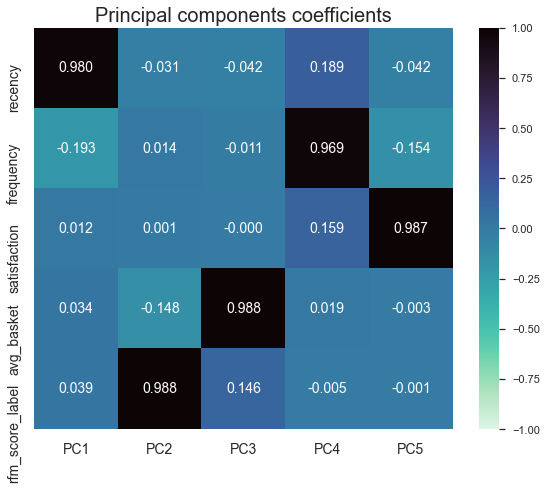

In [90]:
plt.figure(figsize=(8,7))
plt.title("Principal components coefficients", size=20)

ax = sns.heatmap(df_pca_reduced, vmin=-1, vmax=1, center=0, cmap="mako_r",
                annot=True, annot_kws={"size": 14}, fmt=".3f")

plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()
plt.savefig("images/principal-components-coefficients.png")
plt.show()

<div class="alert alert-block alert-info">
    Plotting the <b>Scree of eigenvalues</b>
</div>

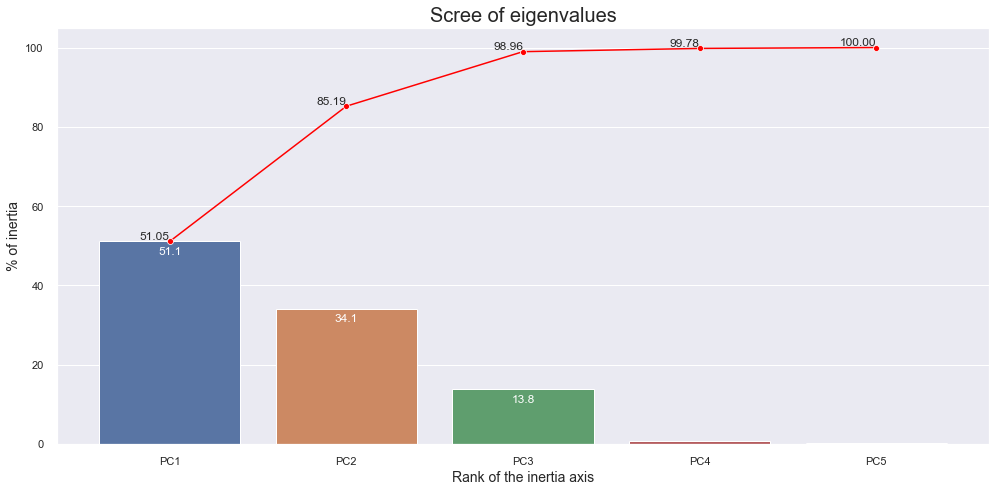

In [29]:
scree = pca.explained_variance_ratio_*100

fig = plt.subplots(figsize=(14, 7))
plot_bar = sns.barplot(x=df_pca.columns, y=scree)
for p in plot_bar.patches:
    plot_bar.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="bottom", xytext=(0, -15), textcoords="offset points", color="white")
plot_line = sns.lineplot(x=df_pca.columns, y=scree.cumsum(), marker="o", color="red")

for x, y in zip(df_pca.columns, scree.cumsum()):
    plot_line.text(x, y, "{:.2f}".format(y), ha="right", va="bottom")

plt.xlabel("Rank of the inertia axis", size=14)
plt.ylabel("% of inertia", size=14)
plt.title("Scree of eigenvalues", size=20)
plt.tight_layout()
plt.savefig("images/scree-of-eigenvalues.png")
plt.show()

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation Circle</b>
</div>

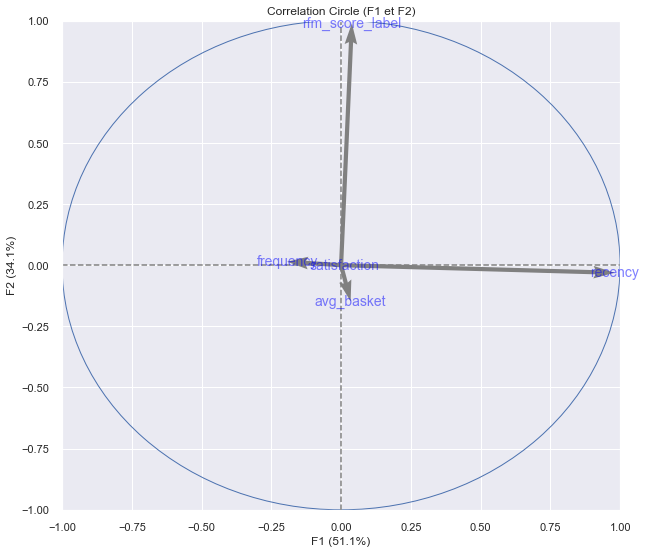

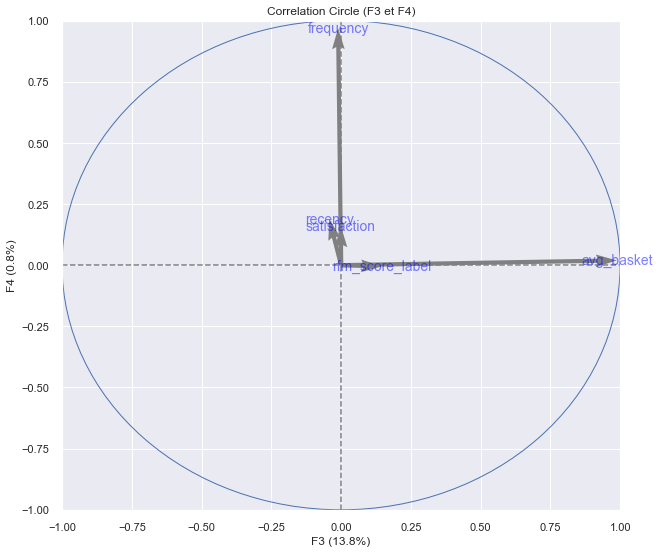

In [30]:
display_circles(pca.components_, n_comp, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))

<div class="alert alert-block alert-info">
    Plotting the <b>Projection of individuals</b>
</div>

In [31]:
X_projected = pca.transform(X)
index_values_sample = pd.Series(index_values).sample(100)

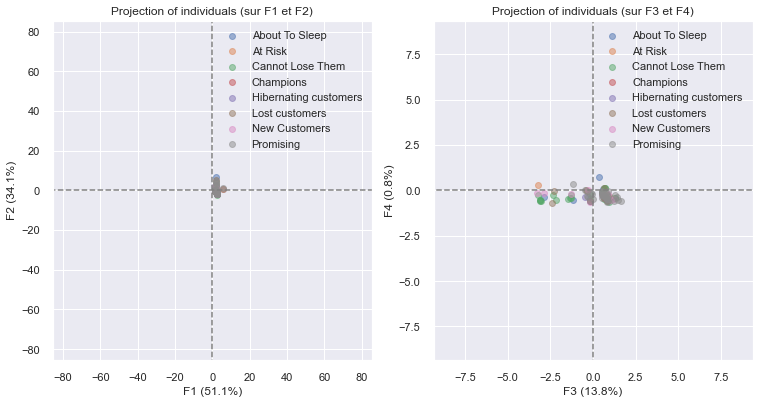

In [32]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], 
                         labels=np.array(index_values_sample), illus_var=data_sample.loc[index_values_sample, "rfm_score_label"], 
                         lab_on=False, alpha = 0.5)

<div class="alert alert-block alert-info">
    Keeping the <b>90% of the variance of the components</b>
</div>

In [33]:
var_threshold=0.90

# Processing the PCA
pca = decomposition.PCA()
pca.fit(X)

# Getting the explained variance ratio for each principal component
scree = pca.explained_variance_ratio_

# Getting the number of principal components to reach variance thresholds
mask = scree.cumsum() > var_threshold
nb_selected_components = len(scree[~mask]) + 1
print("Number of selected components:", nb_selected_components)

# Compute and displays the actual ratio of explained variance
explained_variance_sum = scree.cumsum()[nb_selected_components-1]
print("Cumulative explained variance:  {:.2f}%".format(explained_variance_sum*100))

# Getting the projection of the data on the first components
X_PCA = pca.transform(X)[:,:nb_selected_components]

Number of selected components: 3
Cumulative explained variance:  98.96%


In [34]:
COL_TO_PC =  ["PC" + str(i + 1) for i in range(nb_selected_components)]

In [35]:
df_worked = pd.DataFrame(data=X_PCA, columns=COL_TO_PC, index=index_values)

In [36]:
df_worked.head(5)

,PC1,PC2,PC3
0,2.701340,-1.580367,0.617224
1,2.719635,-1.079095,0.691419
2,2.675058,-2.088678,0.541481
3,1.781497,0.212651,0.920086
4,1.756414,-0.429467,0.824936


In [37]:
df_worked.shape

(66934, 3)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. K-Means</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Number of Cluster</h3>
</div>

In [38]:
X_PCA

array([[ 2.70133972, -1.58036696,  0.61722449],
       [ 2.71963532, -1.07909525,  0.69141938],
       [ 2.67505839, -2.08867777,  0.54148146],
       ...,
       [ 1.63910786,  4.77198781, -2.45536299],
       [ 1.5780722 ,  0.69969752, -0.02983021],
       [-0.50117483, -0.40263653,  0.88498403]])

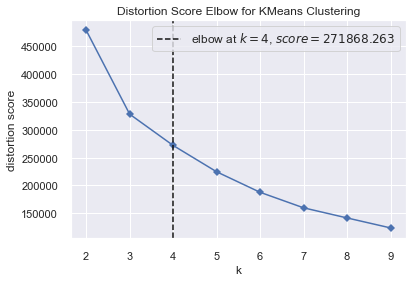

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(df_worked)
visualizer.show()

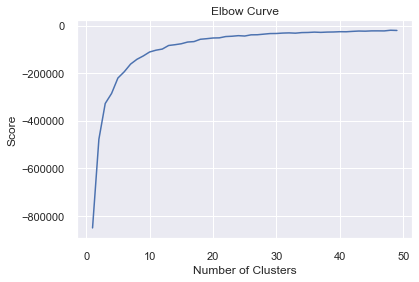

In [41]:
# Run a number of tests, for 1, 2, ... num_clusters
num_clusters = 50
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(df_worked).score(df_worked) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [29]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-info">
    First of all, we are going to work on deafult mode for the model
</div>

In [ ]:
model = KMeans(init="random", n_clusters="4", n_init=10)

In [ ]:
label  = model.fit_predict(df_data_PCA)

In [ ]:
# centroids = model.cluster_centers_
u_labels = np.unique(label)

In [ ]:
# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_data_PCA.iloc[label==i, 0], df_data_PCA.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. K-means</h3>
</div>

<div class="alert alert-block alert-info">
    First of all, we are going to work on deafult mode for the model
</div>

In [ ]:
https://www.scikit-yb.org/en/latest/

https://www.youtube.com/watch?v=4b5d3muPQmA
- forma
    -- centroide??
        -- homogeneidad
        -- Separacion de cluster -- SKL=
         union --> index davies bouldin
         silhouette -> escoger la cantidad de cluster y ver la estabilidad
- estabilidad
- coherencia


- ARI, pour Adjusted Rand Index

https://towardsdatascience.com/clustering-algorithms-for-customer-segmentation-af637c6830ac
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
https://www.youtube.com/watch?v=EItlUEPCIzM
https://datascientest.com/algorithme-des-k-means.
https://realpython.com/k-means-clustering-python/

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Optimization</h3>
</div>

<div class="alert alert-block alert-info">
    List of models to use. for now, in default mode
</div>

- Clustering hiérarchique
- k-means
- DBScan

https://www.definitions-marketing.com/definition/segmentation-rfm/<br>
https://lms.simplilearn.com/courses/4414/Introduction-to-Supervised-&-Unsupervised-Machine-Learning/syllabus<br>

https://classroom.udacity.com/courses/st101<br>
https://classroom.udacity.com/courses/ud827<br>
https://www.freecodecamp.org/news/free-machine-learning-course-10-hourse/<br>

https://towardsdatascience.com/10-highly-probable-data-scientist-interview-questions-fd83f7414760<br>